#                   Flower Recognition  Using CNN Keras

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [45]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [46]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR=r'C:\Users\lenovo\Downloads\archive (4)\train\daisy'
FLOWER_SUNFLOWER_DIR=r'C:\Users\lenovo\Downloads\archive (4)\train\sunflower'
FLOWER_TULIP_DIR=r'C:\Users\lenovo\Downloads\archive (4)\train\tulip'
FLOWER_DANDI_DIR=r'C:\Users\lenovo\Downloads\archive (4)\train\dandelion'
FLOWER_ROSE_DIR=r'C:\Users\lenovo\Downloads\archive (4)\train\rose'


In [47]:
def assign_label(img,flower_type):
    return flower_type

In [48]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [49]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 192.20it/s]

86


In [50]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))


100%|███████████████████████████████████████████████████████████████████████████████| 495/495 [00:02<00:00, 189.45it/s]

581


In [51]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 533/533 [00:02<00:00, 192.62it/s]

1114


In [15]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|███████████████████████████████████████████████████████████████████████████████| 345/345 [00:01<00:00, 281.56it/s]

2646


In [13]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|████████████████████████████████████████████████████████████████████████████████| 497/497 [00:05<00:00, 96.04it/s]

1956


## 2.2 ) Visualizing some Random Images

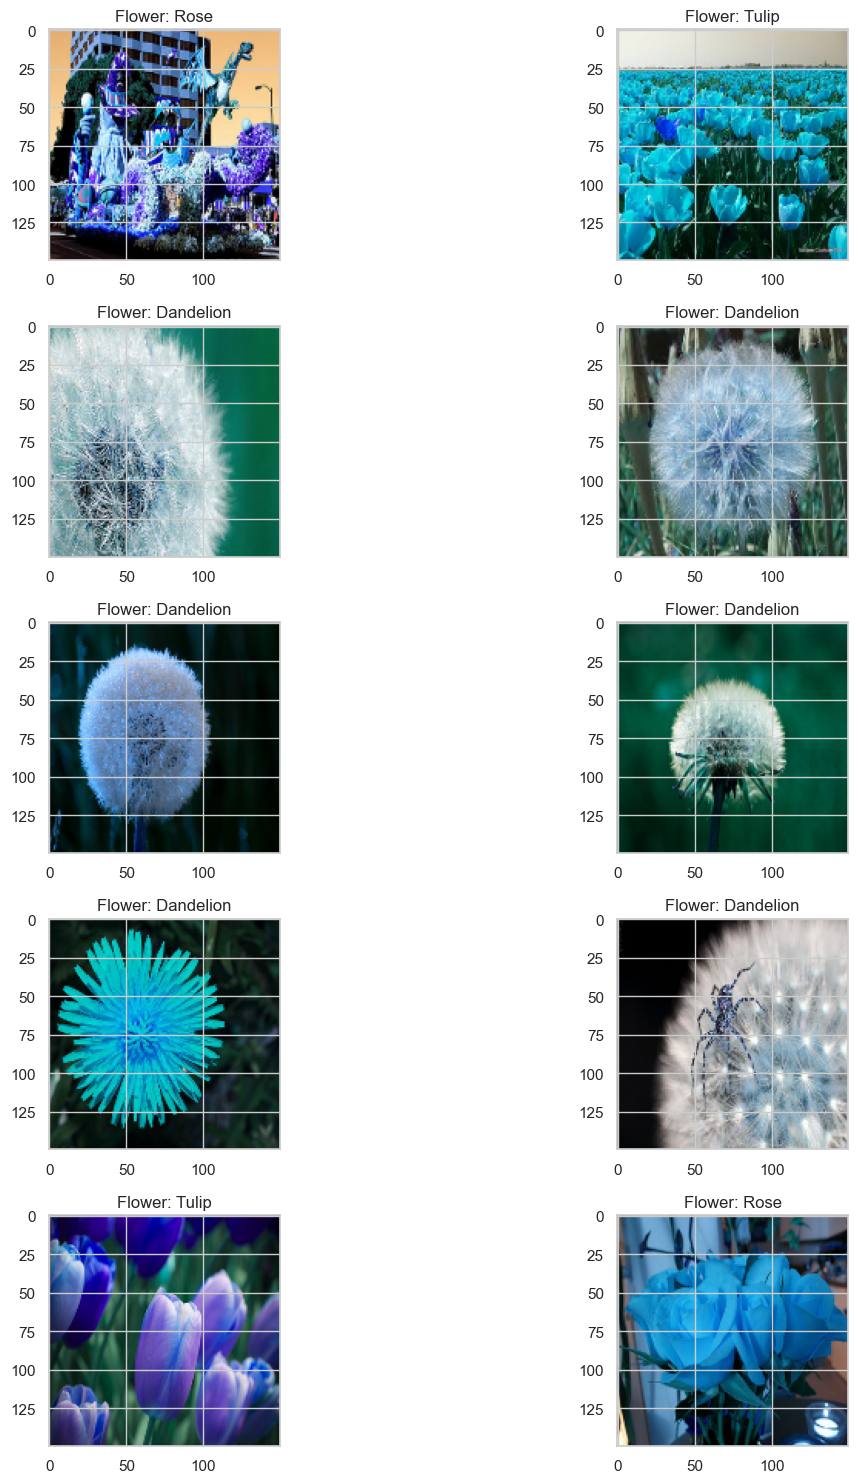

In [16]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [41]:
# Label encoding is a technique
# used in machine learning to
# convert categorical data,
# specifically labels, into
# numerical values.

le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255
print(X[:1])

[[[[8.14717295e-13 7.85620249e-13 7.81983118e-13]
   [8.00168772e-13 7.74708856e-13 7.60160333e-13]
   [8.21991557e-13 7.89257380e-13 7.78345987e-13]
   ...
   [5.09198309e-14 3.27341770e-14 3.27341770e-14]
   [6.18312233e-14 4.00084386e-14 4.36455694e-14]
   [4.36455694e-14 2.54599155e-14 2.90970463e-14]]

  [[8.18354426e-13 7.89257380e-13 7.85620249e-13]
   [8.40177211e-13 8.11080164e-13 8.03805903e-13]
   [8.14717295e-13 7.85620249e-13 7.81983118e-13]
   ...
   [5.45569617e-14 4.36455694e-14 4.72827002e-14]
   [4.72827002e-14 2.54599155e-14 3.27341770e-14]
   [4.36455694e-14 2.90970463e-14 2.54599155e-14]]

  [[8.54725734e-13 8.25628687e-13 8.25628687e-13]
   [8.40177211e-13 8.11080164e-13 8.00168772e-13]
   [8.32902949e-13 8.11080164e-13 8.07443033e-13]
   ...
   [5.81940925e-14 5.09198309e-14 5.09198309e-14]
   [4.72827002e-14 2.54599155e-14 3.27341770e-14]
   [2.90970463e-14 1.45485231e-14 1.09113923e-14]]

  ...

  [[6.61957802e-13 6.40135018e-13 6.43772148e-13]
   [6.83780587e-

## 2.4 ) Splitting into Training and Validation Sets

In [18]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [19]:
np.random.seed(42)
rn.seed(42)
# tf.set_random_seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [20]:
# # modelling starts using a CNN.
# strides -->trides refer to the
# step size that the filter or pooling
# window takes while sliding over the
# input data

# --> MaxPooling2D working
# Input Feature Map:
# | 1 | 2 | 3 | 4 |
# | 5 | 6 | 7 | 8 |
# | 9 |10 |11 |12 |
# |13 |14 |15 |16 |

# MaxPooling (2x2 window, strides=2):
# | 6 | 8 |
# |14 |16 |

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [21]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

# ReduceLROnPlateau is a callback in machine learning frameworks, such as TensorFlow and Keras, that is used to dynamically
# adjust the learning rate during training.
# The purpose of this callback is to monitor a specified metric (usually the validation loss or accuracy) and
# reduce the learning rate when the monitored metric stops improving

## 3.3 ) Data Augmentation to prevent Overfitting

In [22]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [23]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

> Indented block



In [25]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

C:\Users\lenovo\AppData\Local\Temp\ipykernel_7108\3300121015.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/50



15/15 [==============================] - 64s 4s/step - loss: 1.3644 - accuracy: 0.4057 - val_loss: 1.1908 - val_accuracy: 0.4970
Epoch 2/50
15/15 [==============================] - 52s 3s/step - loss: 1.1168 - accuracy: 0.5533 - val_loss: 1.0986 - val_accuracy: 0.5257
Epoch 3/50
15/15 [==============================] - 52s 3s/step - loss: 0.9787 - accuracy: 0.6169 - val_loss: 0.9336 - val_accuracy: 0.6390
Epoch 4/50
15/15 [==============================] - 52s 3s/step - loss: 0.9268 - accuracy: 0.6412 - val_loss: 0.9001 - val_accuracy: 0.6420
Epoch 5/50
15/15 [==============================] - 53s 3s/step - loss: 0.8733 - accuracy: 0.6579 - val_loss: 0.8543 - val_accuracy: 0.6616
Epoch 6/50
15/15 [==============================] - 52s 3s/step - loss: 0.8506 - accuracy: 0.6740 - val_loss: 0.7979 - val_accuracy: 0.6888
Epoch 7/50
15/15 [==============================] - 51s 3s/step - loss: 0.8117 - accuracy: 0.6832 - val_loss: 0.7738 - val_accuracy: 0.7009
Epoch 8/50
15/15 [=============

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

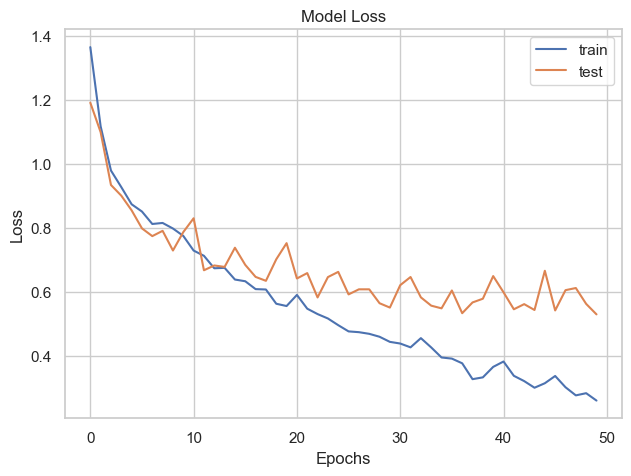

In [26]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test']) 
plt.show()

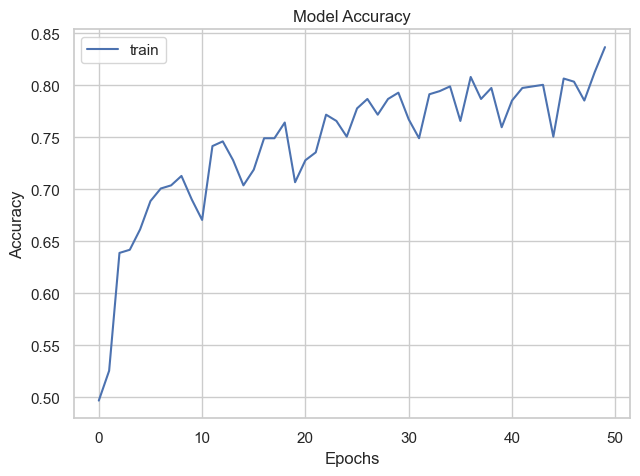

In [29]:
# plt.plot(History.history['acc'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


In [30]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

21/21 [==============================] - 5s 174ms/step


In [31]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

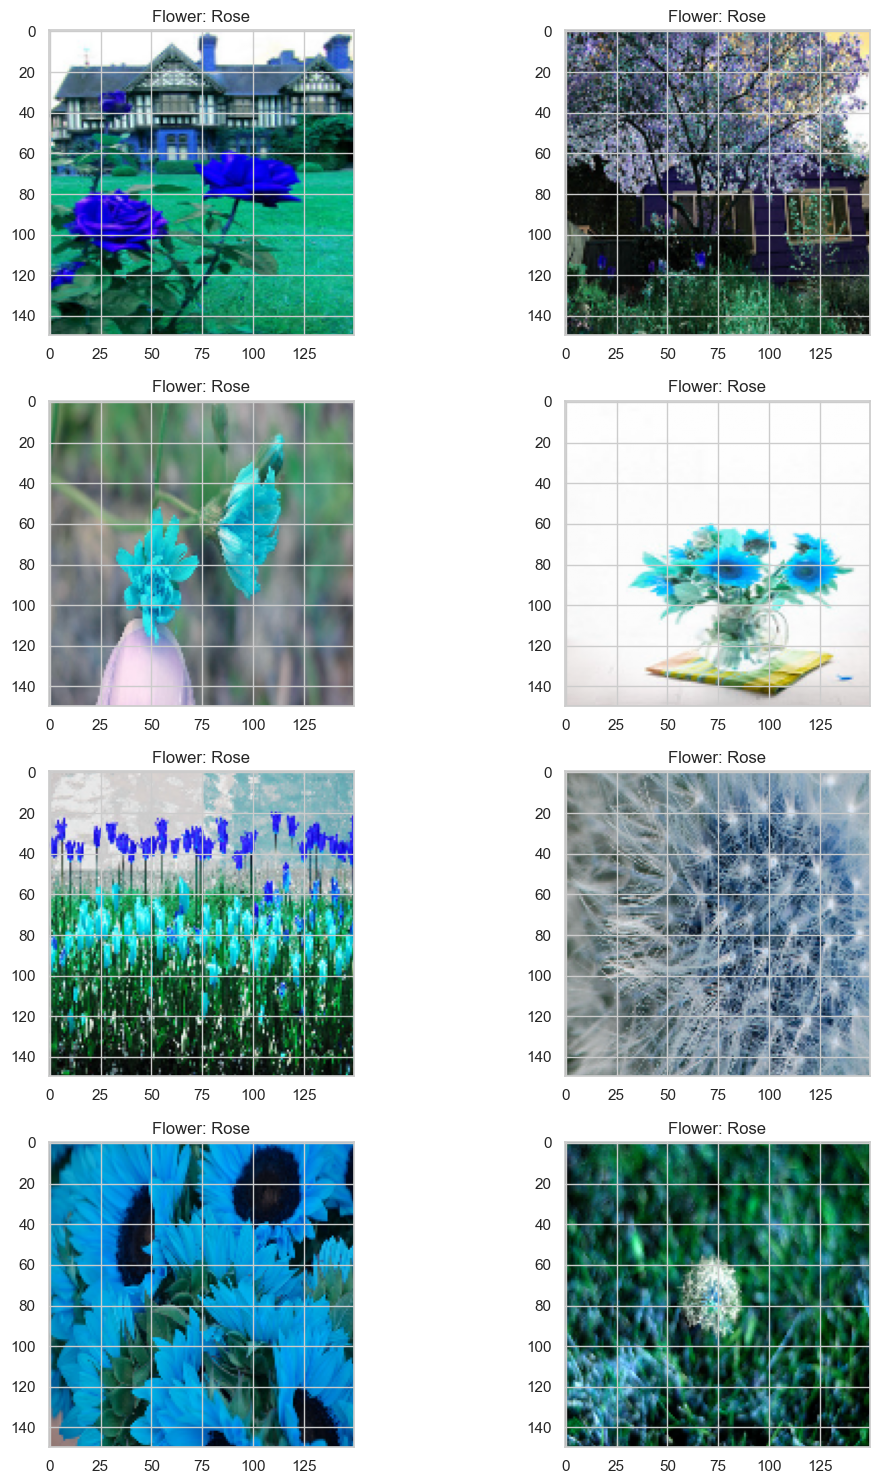

In [35]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title('Flower: '+Z[l])
        # ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

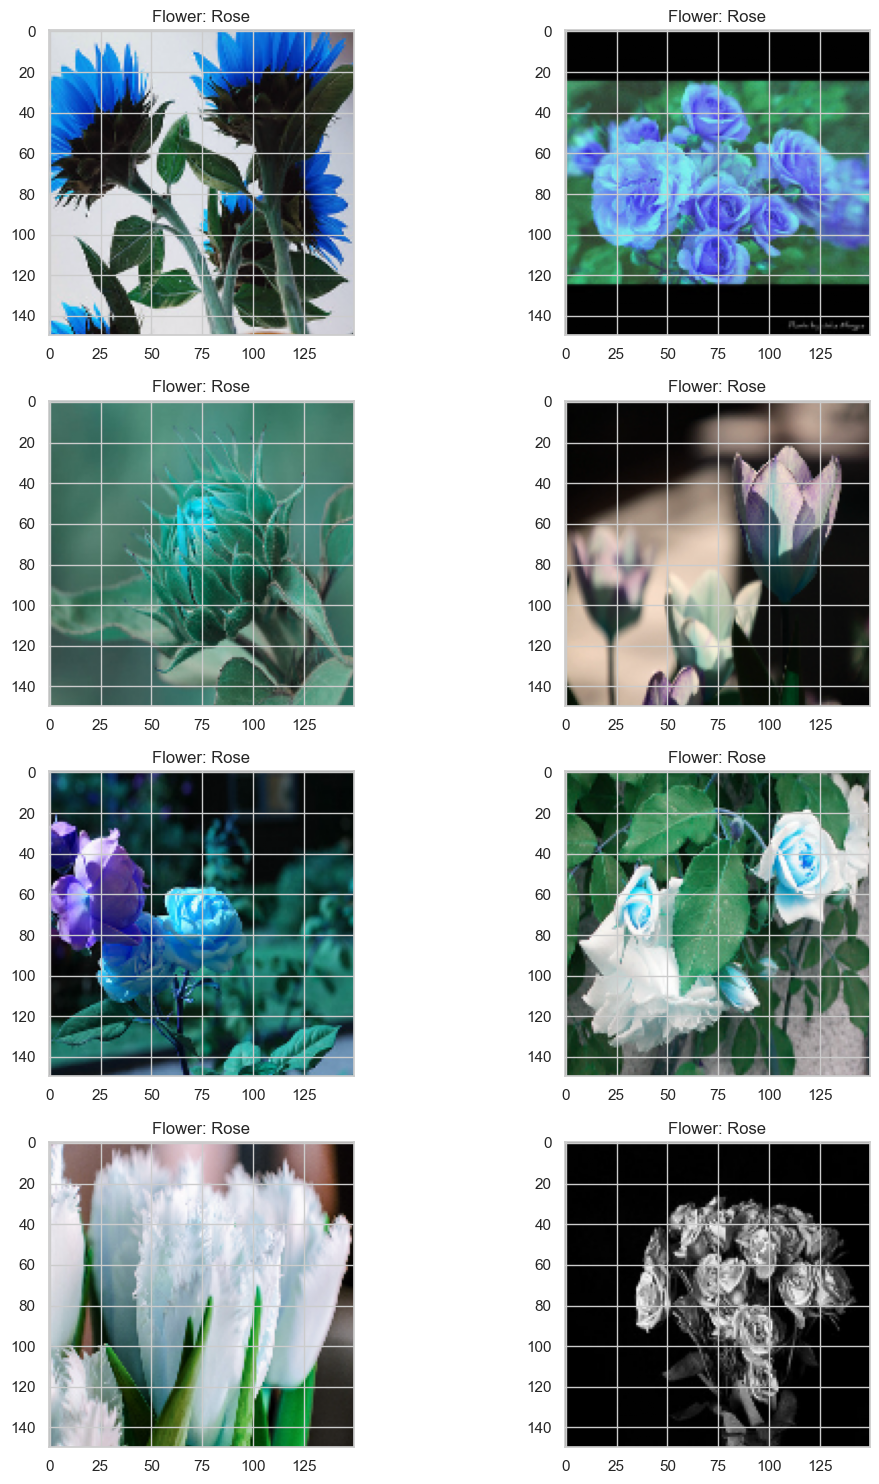

In [37]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title('Flower: '+Z[l])
        # ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1